In [1]:
"""

"""

'\n\n'

In [2]:
is_skip = True
# Data params
batch_size = 256
min_encode_len = 30
max_encode_len = 300
pred_len = 30

valid_start_date = "2020-01-01"

# Model params
d_model = 128
nhead = 4
d_ff = 256
dropout = 0.1
num_layers = 4

# Import

In [3]:
import copy
import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm

import torch
from pytorch_model_summary import summary

device = torch.device("cuda:0")

# Data

In [4]:
if not is_skip:
    # Read transaction
    df_trans = pd.read_csv("../HnM/transactions_train.csv", parse_dates=["t_dat"], dtype={"article_id":str})
    df_meta = pd.read_csv("../HnM/articles.csv", dtype={"article_id":str})
    df_raw = pd.merge(df_trans, df_meta, on="article_id")

In [5]:
def preprocess(data, min_size=2):
    data = data.copy()

    # Make sales
    data = data.groupby(["t_dat", "article_id"], as_index=False).agg(sales=("customer_id", "count"))

    # Expand dates
    data = data.set_index("t_dat").groupby(["article_id"], as_index=False).resample("1D").asfreq().reset_index()
    data["sales"] = data["sales"].fillna(0)
    data["article_id"] = data["article_id"].fillna(method="ffill")

    # Temporal information
    data["month"] = data["t_dat"].dt.month
    
    # Cyclic transformation
    def append_cyclic(col, cycle):
        data[f"{col}_sin"] = np.sin(2 * np.pi * data[col]/cycle)
        data[f"{col}_cos"] = np.cos(2 * np.pi * data[col]/cycle)
    append_cyclic("month", 12)
    
    # Data to list
    data = data.groupby("article_id", as_index=False)[["sales", "month_sin", "month_cos"]].agg(list)

    # Size restriction
    data["size"] = data["sales"].str.len()
    data = data[data["size"] >= min_size]
    return data

if not is_skip:
    df_prep = df_raw[df_raw["index_name"]=="Ladieswear"].reset_index(drop=True)
    
    df_train = df_prep[df_prep["t_dat"] < valid_start_date]
    df_train = preprocess(df_train, min_size=min_encode_len+pred_len)
    df_train.to_parquet("df_train.pq")

    df_valid = df_prep[df_prep["t_dat"] >= valid_start_date]
    df_valid = preprocess(df_valid, min_size=min_encode_len+pred_len)
    df_valid.to_parquet("df_valid.pq")    

In [6]:
df_train = pd.read_parquet("df_train.pq")
df_valid = pd.read_parquet("df_valid.pq")

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, pred_len, min_encode_len, is_valid=False):
        self.pred_len, self.min_encode_len, self.is_valid = pred_len, min_encode_len, is_valid
        
        self.sales = data["sales"].values
        self.month_sin = data["month_sin"].values
        self.month_cos = data["month_cos"].values
    
    def __len__(self):
        return self.sales.shape[0]
    
    def __getitem__(self, idx):
        sales = self.sales[idx].reshape(-1, 1)
        sales = np.log1p(sales)
        month_sin = self.month_sin[idx]
        month_cos = self.month_cos[idx]
        temporal = np.stack([month_sin, month_cos], axis=1)

        # X, y split
        hist = sales[:-self.pred_len]
        hist_temporal = temporal[:-self.pred_len]

        y = sales[-self.pred_len:]
        y_temporal = temporal[-self.pred_len:]

        # Random masking
        if not self.is_valid:
            mask = np.random.randint(0, len(hist)-self.min_encode_len+1)
            hist = hist[mask:]
            hist_temporal = hist_temporal[mask:]

        return {"hist": hist,
                "hist_temporal": hist_temporal,
                "y": y,
                "y_temporal": y_temporal
                }

def collate_fn(batch_list):
    hist = [torch.FloatTensor(batch["hist"]) for batch in batch_list]
    hist_temporal = [torch.FloatTensor(batch["hist_temporal"]) for batch in batch_list]
    y = torch.FloatTensor([batch["y"] for batch in batch_list])
    y_temporal = torch.FloatTensor([batch["y_temporal"] for batch in batch_list])

    hist = torch.nn.utils.rnn.pad_sequence(hist, padding_value=-99, batch_first=True)
    hist_temporal = torch.nn.utils.rnn.pad_sequence(hist_temporal, padding_value=-99, batch_first=True)
    return {"hist": torch.FloatTensor(hist),
            "hist_temporal": torch.FloatTensor(hist_temporal),
            "y": torch.FloatTensor(y),
            "y_temporal": torch.FloatTensor(y_temporal)
            }

train_dataset = Dataset(df_train, pred_len, min_encode_len)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

valid_dataset = Dataset(df_valid, pred_len, min_encode_len, is_valid=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

for data in train_dataloader:
    print("hist", data["hist"].shape)
    print("hist_temporal", data["hist_temporal"].shape)
    print("y", data["y"].shape)
    print("y_temporal", data["y_temporal"].shape)
    break

hist torch.Size([256, 411, 1])
hist_temporal torch.Size([256, 411, 2])
y torch.Size([256, 30, 1])
y_temporal torch.Size([256, 30, 2])


/tmp/ipykernel_2048477/1759873257.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343962757/work/torch/csrc/utils/tensor_new.cpp:245.)
  y = torch.FloatTensor([batch["y"] for batch in batch_list])


# Architecture

In [7]:
class Transformer(torch.nn.Module):
    def __init__(self, pred_len, d_model, nhead):
        super().__init__()
        
        # Preprocess
        self.pred_len = pred_len
        self.temporal_linear = torch.nn.Linear(2, d_model)
        self.hist_linear = torch.nn.Linear(1, d_model)

        # Encoder and Decoder
        self.encoder = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(d_model, nhead, batch_first=True), num_layers)
        self.decoder = torch.nn.TransformerDecoder(torch.nn.TransformerDecoderLayer(d_model, nhead, batch_first=True), num_layers)

        # Final
        self.fianl_linear = torch.nn.Linear(d_model, 1)
    
    def get_paddingmask(self, data):
        return torch.where(data==-99, -torch.inf, 0).to(device)

    def forward(self, hist, hist_temporal, y_temporal):
        # Mask
        padding_mask = self.get_paddingmask(hist.squeeze(-1))

        # Temporal
        temporal = torch.concat([hist_temporal, y_temporal], dim=1)
        temporal = self.temporal_linear(temporal)
        hist_temporal = temporal[:, :-self.pred_len, :]
        y_temporal = temporal[:, -self.pred_len:, :]

        # Sales
        hist = self.hist_linear(hist) + hist_temporal

        # Encoder
        encoder_output = self.encoder(hist, src_key_padding_mask=padding_mask)
        # Decoder
        decoder_output = self.decoder(tgt=y_temporal, memory=encoder_output, memory_key_padding_mask=padding_mask)
        
        # Final
        output = self.fianl_linear(decoder_output)

        return output

model = Transformer(pred_len, d_model, nhead)
model.to(device)
summary(model,
        data["hist"].to(device),
        data["hist_temporal"].to(device),
        data["y_temporal"].to(device),
        show_parent_layers=True, print_summary=True)

--------------------------------------------------------------------------------------------
   Parent Layers            Layer (type)        Output Shape         Param #     Tr. Param #
     Transformer                Linear-1     [256, 441, 128]             384             384
     Transformer                Linear-2     [256, 411, 128]             256             256
     Transformer    TransformerEncoder-3     [256, 411, 128]       2,372,096       2,372,096
     Transformer    TransformerDecoder-4      [256, 30, 128]       2,637,312       2,637,312
     Transformer                Linear-5        [256, 30, 1]             129             129
Total params: 5,010,177
Trainable params: 5,010,177
Non-trainable params: 0
--------------------------------------------------------------------------------------------


'--------------------------------------------------------------------------------------------\n   Parent Layers            Layer (type)        Output Shape         Param #     Tr. Param #\n============================================================================================\n     Transformer                Linear-1     [256, 441, 128]             384             384\n     Transformer                Linear-2     [256, 411, 128]             256             256\n     Transformer    TransformerEncoder-3     [256, 411, 128]       2,372,096       2,372,096\n     Transformer    TransformerDecoder-4      [256, 30, 128]       2,637,312       2,637,312\n     Transformer                Linear-5        [256, 30, 1]             129             129\n============================================================================================\nTotal params: 5,010,177\nTrainable params: 5,010,177\nNon-trainable params: 0\n--------------------------------------------------------------------------

# Train

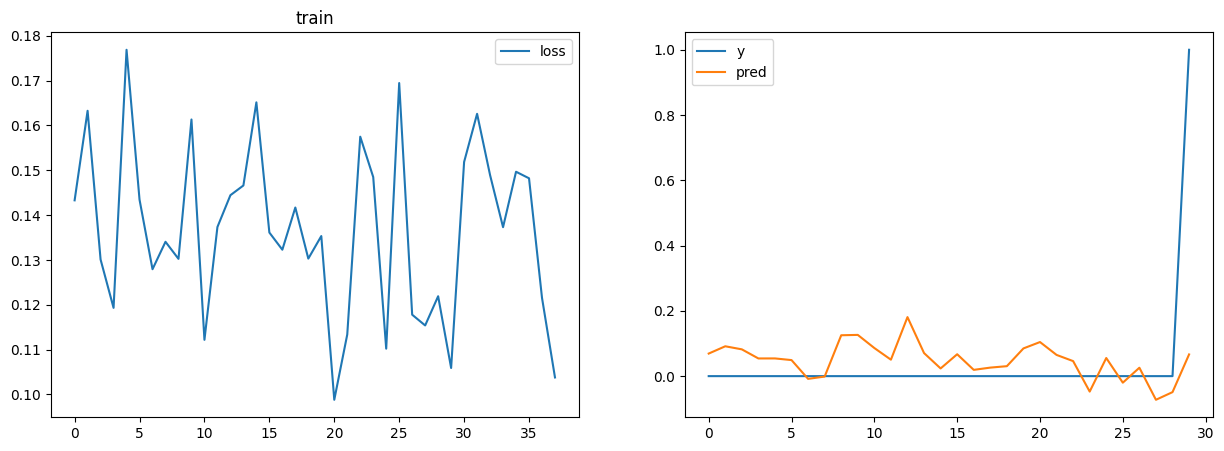

epoch 4 - loss: 0.13669:  70%|███████   | 38/54 [00:15<00:06,  2.40it/s]


KeyboardInterrupt: 

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse_loss = torch.nn.MSELoss()

class Report():
    def __init__(self, window, name):
        self.window, self.name = window, name
        self.loss_li = []

    def plot_sample(self, loss_li, y, pred):
        plt.figure(figsize=(15,5))
        nrows, ncols = 1,2

        plt.subplot(nrows, ncols, 1)
        plt.plot(loss_li, label="loss")
        plt.title(self.name)
        plt.legend()

        plt.subplot(nrows, ncols, 2)
        plt.plot(y, label="y")
        plt.plot(pred, label="pred")
        plt.legend()

        plt.show()

    def report(self, loss, y, pred, pbar, e, isplot=False):
        self.loss_li.append(loss.item())
        pbar.set_description(f"epoch {e} - loss: {np.round(np.mean(self.loss_li[-self.window:]), 5)}")
        
        if isplot:
            clear_output(wait=True)
            self.plot_sample(self.loss_li[-self.window:], y[-1], pred[-1])

def train(e):
    model.train()
    pbar = tqdm(train_dataloader)
    report = Report(window=100, name="train")

    for n, data in enumerate(pbar):
        optimizer.zero_grad()
        pred = model(data["hist"].to(device),
                        data["hist_temporal"].to(device),
                        data["y_temporal"].to(device))
        loss = mse_loss(pred, data["y"].to(device))
        loss.backward()
        optimizer.step()

        report.report(loss, 
                    torch.expm1(data["y"]).squeeze(-1).detach().cpu().numpy(),
                    torch.expm1(pred).squeeze(-1).detach().cpu().numpy(),
                    pbar, e, isplot=True)        
        # break

epoch = 10
for e in range(epoch):
    train(e)